Goal: understand "who" goes to the movies before we get into butter

1.   List item
2.   List item



## Import

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Member_Details_Cineplex4.csv to Member_Details_Cineplex4.csv


## Feature Engineering and Standardizing

In [ ]:
df = pd.read_csv("Member_Details_Cineplex4.csv")

In [ ]:
df['PERC_LATE_EVENING'] = (df['LATE_EVENING'] / df['ALL_VISITS']).fillna(0).replace(np.inf, 0)
df['PERC_PREMIUM'] = (df['PREMIUM_AUDITORIAM_VISITS'] / df['ALL_VISITS']).fillna(0).replace(np.inf, 0)
df['PER_VISIT_REDEEMED'] = (df['TOTAL_PNTS_REDEEMED'] / df['ALL_VISITS']).fillna(0).replace(np.inf, 0)
df.head()

,Unnamed: 0,CINEPLEX_D_Membership_ID,PREMIUM_AUDITORIAM_VISITS,AVERAGE_SPEND,AVERAGE_DISCOUNT,TOTAL_SPEND,TOTAL_REVENUE,TOTAL_DISCOUNT,TOTAL_PNTS_EARNED,FLAG_PNTS_EARNED,TOTAL_PNTS_REDEEMED,FLAG_PNTS_REDEEMED,EARLY_MATINEE,PERC_MATINEE,PERC_OVERNIGHT,PERC_EVENING,PERC_EVENING_NIGHT,EARLY_EVENING,LATE_MATINEE,LATE_EVENING,OVER_MIDNIGHT,ALL_VISITS,TICKETS,AVG_TICKETS,CONCESSION_ITEMS,BUTTER_ITEMS,POPCORN_ITEMS,PERC_FAMILY_VISITS,FAMILY_VISITS,FLAG_CONCESSION,CONCESSION_ITEMS_PER_VISITS,GOES_CONCESSION_PER_VISITS,FLAG_BUTTER,FLAG_POPCORN,PERC_LATE_EVENING,PERC_PREMIUM,PER_VISIT_REDEEMED
0,0,3752,0,9.085000,1.010000,18.17,44.4173,2.02,171,1,1250,1,0,0.500000,0.0,0.500000,0.500000,0,1,1,0,2,3,1.500000,3,1.0,1.0,0.000000,0,1,1.500000,1.500000,1,1,0.500000,0.000000,625.000000
1,1,5052,0,69.170000,7.680000,138.34,148.3400,15.36,1021,1,1000,1,1,0.500000,0.0,0.500000,0.500000,1,0,0,0,2,7,3.500000,16,0.0,1.0,0.000000,0,1,8.000000,8.000000,0,1,0.000000,0.000000,500.000000
2,2,5548,0,14.572083,1.619167,349.73,984.9800,38.86,2681,1,72750,1,1,0.208333,0.0,0.791667,0.791667,14,4,5,0,24,58,2.416667,64,0.0,20.0,0.250000,6,1,2.666667,2.666667,0,1,0.208333,0.000000,3031.250000
3,3,7157,1,20.388571,2.265714,142.72,197.8700,15.86,1140,1,6750,1,0,0.000000,0.0,1.000000,1.000000,7,0,0,0,7,15,2.142857,6,0.0,4.0,0.571429,4,1,0.857143,0.857143,0,1,0.000000,0.142857,964.285714
4,4,15934,0,18.860000,2.100000,18.86,40.3600,2.10,94,1,2500,1,0,0.000000,0.0,1.000000,1.000000,0,0,1,0,1,2,2.000000,4,1.0,1.0,0.000000,0,1,4.000000,4.000000,1,1,1.000000,0.000000,2500.000000


In [ ]:
#df=df[df['FLAG_BUTTER']==1]
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Unnamed: 0,CINEPLEX_D_Membership_ID,PREMIUM_AUDITORIAM_VISITS,AVERAGE_SPEND,AVERAGE_DISCOUNT,TOTAL_SPEND,TOTAL_REVENUE,TOTAL_DISCOUNT,TOTAL_PNTS_EARNED,FLAG_PNTS_EARNED,TOTAL_PNTS_REDEEMED,FLAG_PNTS_REDEEMED,EARLY_MATINEE,PERC_MATINEE,PERC_OVERNIGHT,PERC_EVENING,PERC_EVENING_NIGHT,EARLY_EVENING,LATE_MATINEE,LATE_EVENING,OVER_MIDNIGHT,ALL_VISITS,TICKETS,AVG_TICKETS,CONCESSION_ITEMS,BUTTER_ITEMS,POPCORN_ITEMS,PERC_FAMILY_VISITS,FAMILY_VISITS,FLAG_CONCESSION,CONCESSION_ITEMS_PER_VISITS,GOES_CONCESSION_PER_VISITS,FLAG_BUTTER,FLAG_POPCORN,PERC_LATE_EVENING,PERC_PREMIUM,PER_VISIT_REDEEMED
Unnamed: 0,1.000000,0.999774,-0.064131,-0.072740,-0.072725,-0.077942,-0.080884,-0.077910,-0.092540,-0.134694,-0.027382,-0.030784,-0.099762,-0.074664,0.021668,0.071148,0.074664,-0.037190,-0.068817,0.042971,0.009305,-0.067763,-0.055785,-0.004166,-0.108413,-0.096694,-0.092352,-0.038199,-0.065077,-0.142612,-0.096540,-0.096540,-0.123083,-0.115286,0.081495,-0.062055,0.024252
CINEPLEX_D_Membership_ID,0.999774,1.000000,-0.063833,-0.072531,-0.072515,-0.077388,-0.080465,-0.077355,-0.091845,-0.134266,-0.027944,-0.030335,-0.099365,-0.074448,0.021695,0.070927,0.074448,-0.037150,-0.068412,0.043136,0.009430,-0.067345,-0.055355,-0.004230,-0.107921,-0.096176,-0.091904,-0.038092,-0.064923,-0.142223,-0.096268,-0.096268,-0.123013,-0.115279,0.081817,-0.061925,0.023573
PREMIUM_AUDITORIAM_VISITS,-0.064131,-0.063833,1.000000,0.068936,0.069187,0.573913,0.584159,0.574228,0.549175,0.093060,0.278434,0.123174,0.206467,-0.044851,0.023588,0.040898,0.044851,0.365093,0.277392,0.315675,0.133011,0.520001,0.493427,-0.076115,0.339196,0.228231,0.294870,-0.127722,0.212184,0.067444,-0.082448,-0.082448,0.075851,0.047684,0.038375,0.583845,-0.041303
AVERAGE_SPEND,-0.072740,-0.072531,0.068936,1.000000,0.999997,0.344948,0.259980,0.344978,0.180517,0.293521,-0.208521,-0.269943,-0.057037,0.057101,0.045088,-0.065150,-0.057101,-0.069033,-0.049496,-0.076204,0.016644,-0.108469,0.108788,0.662019,0.270572,0.148684,0.206909,0.102079,0.004680,0.277656,0.595562,0.595562,0.188547,0.285932,-0.053826,0.219854,-0.266087
AVERAGE_DISCOUNT,-0.072725,-0.072515,0.069187,0.999997,1.000000,0.344965,0.260008,0.344997,0.180502,0.293479,-0.208536,-0.270009,-0.057035,0.057010,0.045078,-0.065057,-0.057010,-0.068993,-0.049501,-0.076145,0.016664,-0.108424,0.108874,0.662124,0.270455,0.148662,0.206862,0.101942,0.004640,0.277433,0.595379,0.595379,0.188438,0.285742,-0.053775,0.220253,-0.266180
TOTAL_SPEND,-0.077942,-0.077388,0.573913,0.344948,0.344965,1.000000,0.968423,0.999999,0.902651,0.210601,0.163641,0.134247,0.274255,-0.004204,0.017925,0.001097,0.004204,0.553994,0.419093,0.381066,0.136734,0.729488,0.846184,0.135383,0.794995,0.445506,0.707222,-0.025620,0.478044,0.246942,0.188115,0.188115,0.227233,0.272349,-0.015735,0.118895,-0.227824
TOTAL_REVENUE,-0.080884,-0.080465,0.584159,0.259980,0.260008,0.968423,1.000000,0.968440,0.904906,0.180965,0.350797,0.217518,0.284130,-0.014671,0.018836,0.011441,0.014671,0.587099,0.439045,0.420482,0.148308,0.775511,0.906141,0.144646,0.812798,0.458420,0.726312,-0.023686,0.514729,0.234998,0.161981,0.161981,0.221652,0.260567,-0.003495,0.098284,-0.105741
TOTAL_DISCOUNT,-0.077910,-0.077355,0.574228,0.344978,0.344997,0.999999,0.968440,1.000000,0.902566,0.210600,0.163635,0.134211,0.274259,-0.004241,0.017935,0.001132,0.004241,0.554012,0.418946,0.381142,0.136780,0.729469,0.846294,0.135468,0.794752,0.445500,0.707030,-0.025670,0.478009,0.246848,0.188018,0.188018,0.227170,0.272263,-0.015703,0.119129,-0.227862
TOTAL_PNTS_EARNED,-0.092540,-0.091845,0.549175,0.180517,0.180502,0.902651,0.904906,0.902566,1.000000,0.206303,0.170373,0.160450,0.358054,0.022077,0.008876,-0.023699,-0.022077,0.573328,0.517189,0.385269,0.134607,0.814495,0.813799,-0.003927,0.797131,0.423703,0.714208,-0.024429,0.523894,0.239918,0.149490,0.149490,0.211767,0.258892,-0.031014,0.066803,-0.225749
FLAG_PNTS_EARNED,-0.134694,-0.134266,0.093060,0.293521,0.293479,0.210601,0.180965,0.210600,0.206303,1.000000,-0.103172,-0.161637,0.067366,0.0199

In [ ]:
list_columns=['ALL_VISITS','PERC_EVENING_NIGHT','AVERAGE_SPEND','FLAG_PNTS_REDEEMED']
list_columns_final=['CINEPLEX_D_Membership_ID','CONCESSION_ITEMS_PER_VISITS',\
                    'ALL_VISITS','PERC_EVENING_NIGHT','AVERAGE_SPEND','FLAG_PNTS_REDEEMED','FLAG_POPCORN','CONCESSION_ITEMS','PREMIUM_AUDITORIAM_VISITS','TOTAL_DISCOUNT'\
                    ,'FLAG_CONCESSION','AVG_TICKETS','PERC_FAMILY_VISITS','TOTAL_PNTS_EARNED','TOTAL_PNTS_REDEEMED','FLAG_BUTTER','clusters']
#BEST TO DATE. 
df_filtered = df.loc[:, (list_columns)]

In [ ]:
#df.iloc[df.values==np.inf]

Standardizing

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scale = MinMaxScaler()

df_scaled = df_filtered.copy()
df_scaled[(list_columns)] =  scale.fit_transform(df_scaled[(list_columns)])
df_scaled.head()

,ALL_VISITS,PERC_EVENING_NIGHT,AVERAGE_SPEND,FLAG_PNTS_REDEEMED
0,0.011364,0.500000,0.010796,1.0
1,0.011364,0.500000,0.082198,1.0
2,0.261364,0.791667,0.017317,1.0
3,0.068182,1.000000,0.024229,1.0
4,0.000000,1.000000,0.022412,1.0


## Visualizing Dendogram (change p to see different groupings)

In [ ]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

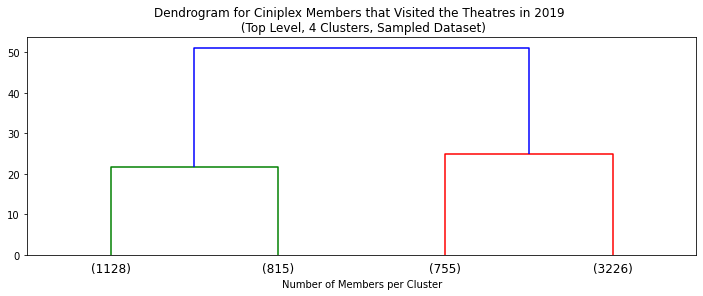

In [ ]:
# graph function from sklearn website: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

X = df_scaled

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
#affinity default = euclidean

model = model.fit(X)
plt.figure(figsize=(12,4)) #width, height
plt.title('Dendrogram for Ciniplex Members that Visited the Theatres in 2019 \n (Top Level, 4 Clusters, Sampled Dataset)')

# plot the top two levels of the dendrogram, setting the "p" changes the threshold
plot_dendrogram(model, truncate_mode='level', p=1)
plt.xlabel("Number of Members per Cluster")
plt.show()

Fitting Model Using Selected Clusters Based on Choice Image

Testing Distance ... not totally sure how this works but its popular on google?

      number of clusters    silhouette score
--  --------------------  ------------------
 0                     3            0.590849
 1                     4            0.624935
 2                     5            0.596952
 3                     6            0.591163
 4                     7            0.593975


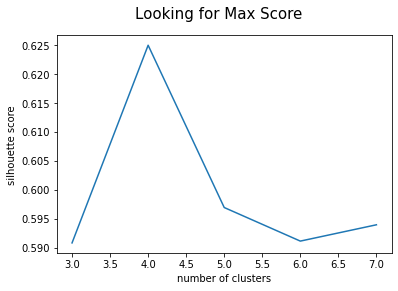

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples
from tabulate import tabulate

nclusters = [] 
sil_score = []

for n in (3,4,5,6,7):
  model = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
  model.fit(X)
  labels = model.labels_
  silhouette = silhouette_score(X, model.labels_)
  nclusters.append(n)
  sil_score.append(silhouette)
    
output = list(zip(nclusters,sil_score)) 
choice = pd.DataFrame(list(output)) 
choice.columns = ['number of clusters','silhouette score']
print( tabulate(choice, choice.columns) )
plt.plot(choice['number of clusters'], choice['silhouette score'])
plt.suptitle ('Looking for Max Score',fontsize=15)
plt.xlabel ('number of clusters',fontsize=10)
plt.ylabel ('silhouette score',fontsize=10)
plt.show()

In [ ]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
Z = linkage(X,'ward')
c, coph_dists = cophenet(Z, pdist(X))
c

0.9203354323218421

In [ ]:
#Final selection
model = AgglomerativeClustering(n_clusters=4, affinity='euclidean',  linkage='ward')
model.fit(X)
labels = model.labels_
df['clusters'] = labels
df_final = df.loc[:, (list_columns_final)]

## Printing Final Table and Stats

In [ ]:
df_final.head()

,CINEPLEX_D_Membership_ID,AVERAGE_SPEND,AVERAGE_DISCOUNT,AVG_TICKETS,PER_VISIT_EARNED,PERC_LATE_EVENING,clusters
0,3752,9.085000,1.010000,1.500000,85.500000,0.500000,1
1,5052,69.170000,7.680000,3.500000,510.500000,0.000000,0
2,5548,14.572083,1.619167,2.416667,111.708333,0.208333,0
3,7157,20.388571,2.265714,2.142857,162.857143,0.000000,0
4,15934,18.860000,2.100000,2.000000,94.000000,1.000000,2


In [ ]:
for col in list_columns_final:
  print(col)
  print(df_final[(col)].groupby(df_final['clusters']).agg(['count','mean','min','max','sum']))
  print('\n')

CINEPLEX_D_Membership_ID
          count          mean    min       max          sum
clusters                                                   
0          3226  5.265200e+06   3752  10360535  16985533629
1           815  5.256703e+06  23777  10395940   4284212984
2           755  4.642626e+06  17476  10270584   3505182501
3          1128  5.392529e+06  31765  10415139   6082773006


CONCESSION_ITEMS_PER_VISITS
          count      mean  min   max          sum
clusters                                         
0          3226  2.339859  0.0  18.0  7548.385577
1           815  3.466928  0.0  26.0  2825.546443
2           755  2.768136  0.0  18.5  2089.942681
3          1128  2.671640  0.0  16.0  3013.609776


ALL_VISITS
          count      mean  min  max    sum
clusters                                  
0          3226  5.989771    1   44  19323
1           815  3.022086    1   21   2463
2           755  6.123179    1   89   4623
3          1128  3.490248    1   24   3937


PERC_EVENING

In [ ]:
df_final.to_csv('Member_Clusters.csv')
from google.colab import files
files.download('Member_Clusters.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#install pandasql for google colab
!pip install pandasql
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

  Created wheel for pandasql: filename=pandasql-0.7.3-cp36-none-any.whl size=26819 sha256=abb886c6e2032de261338185ffc5858047fdfc3d5dce8cf104d57d7e608bd8d0
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql


In [ ]:
overview_query = '''select clusters, 
  SUM(FLAG_CONCESSION)* 1.0/count(CINEPLEX_D_Membership_ID) AS CONCESSION,
  SUM(FLAG_POPCORN)* 1.0/count(CINEPLEX_D_Membership_ID) AS POPCORN,
  SUM(FLAG_BUTTER)* 1.0/count(CINEPLEX_D_Membership_ID) AS BUTTER
  from df_final
  GROUP BY clusters'''
output = pysqldf(overview_query)
output
#concession conversion impacted, not necessarily conversion to butter or popcorn..some time of days less ppl go to concession

,clusters,CONCESSION,POPCORN,BUTTER
0,0,0.836950,0.715747,0.385927
1,1,0.851534,0.698160,0.348466
2,2,0.790728,0.645033,0.319205
3,3,0.832447,0.670213,0.349291


Understanding

{'boxes': [<matplotlib.lines.Line2D at 0x7f8a2c6d95f8>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8a2c6d9f98>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8a2c5fb9e8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8a2c5fb668>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8a2c6d9668>,
  <matplotlib.lines.Line2D at 0x7f8a2c6d9710>]}

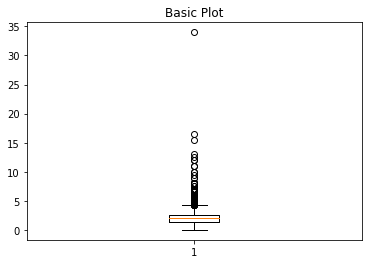

In [ ]:
df.head()
x = df['AVG_TICKETS']
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(x)